Using PINNs to solve the transport equation with periodic boundary conditions

## **Setup**

In [2]:
# Set matplotlib for inline plots
%matplotlib inline
# Set matplotlib default font size\n",
import matplotlib as mpl
mpl.rc('font', size=15)
# Imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## **SpacePeriodicNN Class**

In [223]:
"""
Fully connected feed-forward neural network 

Network takes two arguments (x, t)
Network's output will be L-periodic in x,
    where L is an argument of the NN
Currently, x is a scalar
TODO: Generalize to x in R^d
"""

class SpacePeriodicNN(nn.Module):
    
    def __init__(self, N_h, L=1, activation='tanh'):
        super().__init__()
        
        # Save network parameters
        self.N_in = 3 # 1 for time, 1 for cosine, 1 for sine
        self.N_out = 1
        self.L = L
        
        # Hidden layer size may be int or list of ints
        if isinstance(N_h, int):
            self.N_h = [N_h]
        else:
            self.N_h = N_h
        self.N_layers = len(self.N_h)
        
        # Select the activation function
        if activation == 'tanh':
            activation = nn.Tanh
        elif activation == 'relu':
            activation = nn.ReLU
        elif activation == 'sine':
            activation = torch.sin
        
        # Create the layers
        self.fcs = nn.Sequential(*[
            nn.Linear(self.N_in, self.N_h[0]), 
            activation()
        ])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(self.N_h[i], self.N_h[i+1]),
                activation()
            ]) 
            for i in range(self.N_layers-1)]
        )
        self.fce = nn.Linear(self.N_h[-1], self.N_out)
        
        
    def forward(self, s):
        # # Extract x, t
        # t = s[:,0]
        # x = s[:,1]
        # # Convert x to cos(2 pi x / L) and sine(2 pi x / L) 
        # cos = torch.cos(2 * torch.pi * x / self.L)
        # sin = torch.sin(2 * torch.pi * x / self.L)
        # Concatenate the input into a single tensor
        # nn_input = torch.vstack((t,cos,sin)).t()
        # Run the input through the network
        nn_out = self.fcs(s)
        nn_out = self.fch(nn_out)
        nn_out = self.fce(nn_out)
        return nn_out

## **Mesh Based Training Algorithm**

In [50]:
"""
Functions for computing derivatives of the network's output wrt its input
"""

def compute_u_v(v, u):
    """
    Computes u_v for the independent variable v and dependent variable u
    """
    return torch.autograd.grad(u, v, torch.ones_like(u), create_graph=True)[0]


def compute_u_vv(v, u_v):
    """
    Computes u_vv for the independent variable 'v' and dependent variable 'u' (not a parameter here)
    Must be given u_v, the partial derivative computed using compute_u_v()
    """
    return torch.autograd.grad(u_v, v, torch.ones_like(u_v), create_graph=True)[0]

In [52]:
"""
Function to generate mesh points on [0,1]^d x [0,T]
"""
def generate_mesh(nt, nx, d=1, T=1):
    """
     ARGUMENTS
        
        nt, nx   :   Ints. Number of temporal and spatial interior points
                     for the mesh, respectively
                     
        d        :   Int. Spatial dimension
        
        T        :   Float. Sets time domain to [0,T]
                     Default: 1
    
    RETURNS
    
        mesh_interior     :   (nt * nx^d, d+1)- Torch array of the interior of 
                                the spatiotemporal mesh (t != 0 and x_i \notin {0,1}
                                for all i)
                                
        mesh_boundary     :   (???, d+1) - Torch array of the spatial boundary
                                of the spatiotemporal mesh (x_i = 0 or x_i = 1
                                for some i = 1, ..., d)
                                
        mesh_t0           :   (nx*d, d+1)- Torch array of the t=0 mesh points
        
    
    NOTE: Currently only works with d=1. 
    TODO: Generalize to d > 1
    """
    t_vals = torch.linspace(0,T,steps=nt+2)
    x_vals = torch.linspace(0,1,steps=nx+2)
    
    # Create the interior mesh using meshgrid
    mesh = torch.meshgrid(
        [t_vals] + [x_vals] * d, indexing='ij'
    )
    
    # Break out the boundary, interior and t=0
    # Interior
    mesh_interior = torch.vstack([
        mesh_dim[1:-1,1:-1].ravel() 
        for mesh_dim in mesh
    ])
    # Boundary
    # Left boundary
    left = torch.vstack([
        mesh[0][1:,0], mesh[1][1:,0]
    ])
    # Right boundary
    right = torch.vstack([
        mesh[0][1:,-1], mesh[1][1:,-1]
    ])
    # Combined
    mesh_boundary = torch.hstack((left,right))
    
    # t = 0
    mesh_t0 = torch.vstack([
        mesh[0][0,:], mesh[1][0,:]
    ])
    
    # Return
    return mesh_interior.t(), mesh_boundary.t(), mesh_t0.t()

In [221]:
"""
Mesh-free training algorithm, specific to the SpacePeriodicNN class
"""
def train_on_mesh(network, f_pde, f_ic, nt, nx, 
        alpha=None, n_iters=1000, lr=1e-3, verbose=None, u_exact=None
    ):
    """
    ARGUMENTS
    
        network      :  FCN network to be trained
        
        f_pde        :  Callable. Function that computes the partial derivative based 
                        quantity that should be minimized
        
        f_ic         :  Callable. Function that computes the initial condition 
                        for the PDE that the NN is being trained to solve
                        
        nt, nx       :  Ints. Number of temporal and spatial interior points
                        for the mesh, respectively
                        
        alpha        :  Tuple. Sets the scaling of the three
                        terms in the loss function
                        
                        L = alpha[0] L_pde + alpha[1] * L_ic

                        Default: [1,1]
        
        n_iters      :  Number of training iterations
                        Default: 1000
                        
        lr           :  Learning rate
                        Default: 1e-3
        
        eps_term     :  Float. Train look terminates early if training loss drops below
                        this threshold
                        Default=0.0 (don't break)
        
        u_exact      :  None or Callable function that computes the exact
                        solution given any point in the domain
                        Default: None
    
    RETURNS
    
        L_pde          
        
        L_ic
        
        L_train
        
        L2_err
    """
    
    # Loss coefs alpha[i]
    if alpha is None:
        alpha = [1,1]
    alpha = np.array(alpha, dtype=float)
    
    # Create the optimizer
    optimizer = torch.optim.Adam(network.parameters(),lr=lr)
    
    # Object to compute MSE loss
    mse_loss = nn.MSELoss()
    
    # Arrays to store the losses
    L_pde = np.zeros(n_iters)    # PDE loss
    L_bc = np.zeros(n_iters)     # Initial condition loss
    L_ic = np.zeros(n_iters)     # Initial condition loss
    L_train = np.zeros(n_iters)  # Overall training loss
    if u_exact is not None:
        L2_err = np.zeros(n_iters)  # L2-error on exact solution
        
    # Create the mesh
    mesh_interior, mesh_boundary, mesh_t0 = generate_mesh(nt, nx)
    # Set the interior points to requires grad
    mesh_interior.requires_grad = True
    # Compute the number of boundary points
    n_bndry_pts = mesh_boundary.shape[0]
    # Compute the initial condition at the mesh points
    u_t0 = f_ic(mesh_t0)
    
    # Training loop
    # TODO: make this a tqdm loop
    for i in range(n_iters):
        # Clear the parameter gradients
        optimizer.zero_grad()
        
        # Initial condition loss
        # Compute the network's predictons for mesh_t0
        net_t0 = network(mesh_t0)
        # Initial condition loss
        L_ic_i = mse_loss(u_t0, net_t0) 
        L_ic[i] = L_ic_i.detach() 
        
        # Periodic BC Loss
        net_boundary = network(mesh_boundary)
        net_left_bndry = net_boundary[:n_bndry_pts//2]
        net_right_bndry = net_boundary[n_bndry_pts//2:]
        L_bc_i = mse_loss(net_left_bndry, net_right_bndry)
        L_bc[i] = L_bc_i.detach() 
        
        # PDE loss
        # Compute the NN's output at the interior points
        net_interior = network(mesh_interior)
        # Compute the NN's PDE loss
        L_pde_i = f_pde(mesh_interior, net_interior)
        L_pde[i] = L_pde_i.detach()
        
        # L2 Error on exact solution
        if u_exact is not None:
            # Compute the exact solution on the interior points
            u_interior_pts = u_exact(interior_pts)
            # Compute the network's L2 error on these points
            L2_err[i] = np.sqrt(mse_loss(u_interior_pts, net_interior.detach()))
        
        # Overall loss
        L_train_i = alpha[0] * L_pde_i + alpha[1] * L_ic_i
        L_train[i] = L_train_i.detach()
        
        # Update the network's parameter
        L_train_i.backward()
        optimizer.step()
        
        if verbose and ((i+1) % verbose) == 0:
            fmt_str = 'Iter %d/%d, Losses: PDE=%.2e  BC=%.2e  IC=%.2e  TR=%.2e'
            msg = fmt_str % (i+1, n_iters, L_pde_i, L_bc_i, L_ic_i, L_train_i)
            if u_exact is not None:
                msg += ' L2-err: %.2e' % L2_err[i]
            print(msg)
            
    # Return the loss arrays as np arrays
    losses = [L_pde, L_bc, L_ic, L_train]
    if u_exact is not None:
        losses.append(L2_err)
    return losses

## **Transport**

In [157]:
def f_pde_transport(v, u, a=1):
    """
    PDE loss associated with the transport equation
    u_t + a u_x = 0
    
    Only works for d = 1 right now
    
    ARGUMENTS
    
        v    :   (# points, d+1)-Torch tensor of (t[i], x[i]) pairs where
                     v[i,0] = t[i] and s[i,1:] = x[i]
                     
        u    :   (# points,)-Torch tensor of u[i] = u(t[i], x[i])
        
        a    :   (d,)-Torch tensor. The transport velocity
                 Default: a = [1, 1, ..., d]^t
        
    RETURNS
    
       the PDE loss ... IDK what to call it
    """
    # Set the Transport velocity
    if a is None:
        a = torch.ones(v.shape[1]-1)
    
    # Compute u_t and u_x
    u_v = compute_u_v(v, u)
    # Extract u_t and u_x
    u_t = u_v[:,0]
    u_x = u_v[:,1:]
    
    # Compute Q
    return (u_t + a * u_x).square().mean()



def f_ic_basic_transport(s):
    """
    Basic IC for the transport equation
    Only works for d = 1
    
    s = (t, x)
    """
    return torch.cos(2 * torch.pi * s[:,1]).view(-1,1)

In [129]:
torch.pi

3.141592653589793

In [237]:
"""
------------------------------------------------------------------------
                                The TEST
------------------------------------------------------------------------
"""

"""
Parameters
"""

# Network parameters
N_h = [128, 128]

# Training parameters
nt = 25
nx = 25
alpha = [2,1,1]       # Relative importance of pde / ic loss
n_iters = 1000     # Number of training iterations
lr = 1e-3          # Learning rate
verbose=n_iters//25

"""
Setup
"""
# Set the random seed for reproducibility
seed = np.random.randint(1e6) # 3141
print('Random seed:', seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the network
# network = SpacePeriodicNN(N_h=N_h)

"""
Training Loop
"""
L_pde, L_bc, L_ic, L_train = train_on_mesh(network,
        lambda pts,u: f_pde_transport(pts, u), f_ic_basic_transport, 
        nt, nx, alpha, n_iters, lr, verbose, u_exact=None
    )


Random seed: 937722
Iter 40/1000, Losses: PDE=4.25e-04  BC=5.67e-15  IC=3.72e-04  TR=1.22e-03
Iter 80/1000, Losses: PDE=4.51e-05  BC=1.13e-14  IC=2.25e-05  TR=1.13e-04
Iter 120/1000, Losses: PDE=2.79e-05  BC=3.14e-15  IC=1.11e-05  TR=6.68e-05
Iter 160/1000, Losses: PDE=2.71e-05  BC=7.14e-15  IC=1.03e-05  TR=6.46e-05
Iter 200/1000, Losses: PDE=2.64e-05  BC=4.92e-15  IC=1.00e-05  TR=6.29e-05
Iter 240/1000, Losses: PDE=2.57e-05  BC=7.75e-15  IC=9.71e-06  TR=6.12e-05
Iter 280/1000, Losses: PDE=2.50e-05  BC=7.96e-15  IC=9.44e-06  TR=5.95e-05
Iter 320/1000, Losses: PDE=2.43e-05  BC=5.26e-15  IC=9.19e-06  TR=5.79e-05
Iter 360/1000, Losses: PDE=2.37e-05  BC=3.86e-15  IC=8.95e-06  TR=5.63e-05
Iter 400/1000, Losses: PDE=2.30e-05  BC=2.46e-15  IC=8.72e-06  TR=5.47e-05
Iter 440/1000, Losses: PDE=2.23e-05  BC=6.01e-15  IC=8.49e-06  TR=5.32e-05
Iter 480/1000, Losses: PDE=2.17e-05  BC=2.80e-15  IC=8.28e-06  TR=5.17e-05
Iter 520/1000, Losses: PDE=2.11e-05  BC=2.94e-15  IC=8.07e-06  TR=5.02e-05
Iter 56

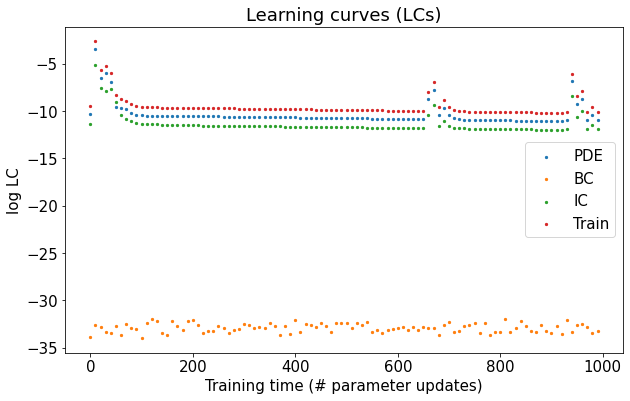

In [238]:
"""
Plot the learning curves
"""
plt.figure(figsize=(10,6))
plt.title('Learning curves (LCs)')
plt.xlabel('Training time (# parameter updates)')
plt.ylabel('log LC')

LCs = [L_pde, L_bc, L_ic, L_train]
labels = ['PDE', 'BC', 'IC', 'Train']
sample_rate = 10
times = sample_rate * np.arange(LCs[0].shape[0] / sample_rate)
for lc,label in zip(LCs, labels):
    plt.scatter(times, np.log(lc[::sample_rate]), label=label, s=5)
plt.legend()
plt.show()

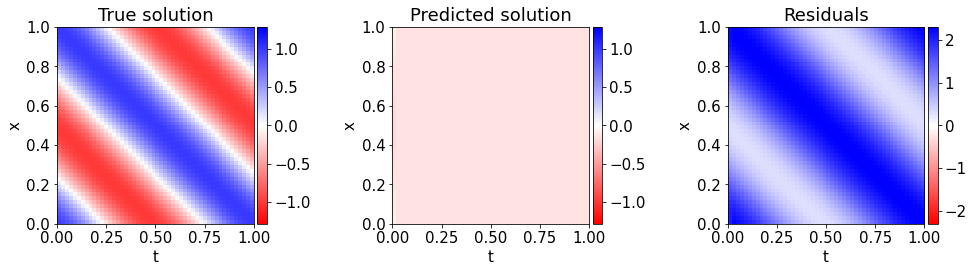

In [239]:
"""
Post training visualization
"""
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_t = 50
n_x = n_t

# Compute the NN's prediction
mesh_interior, mesh_boundary, mesh_t0 = generate_mesh(n_t, n_x)
with torch.no_grad():
    u_pred_interior = network(mesh_interior).view(n_t,-1)

# Compute the exact solution
T = mesh_interior[:,0].reshape((n_t,-1))
X = mesh_interior[:,1].reshape((n_x,-1))
u_exact = np.cos(2 * np.pi * (X - T))

# Heatmap visualization
fig, axs  = plt.subplots(1,3,figsize=(14,4))
for ax in axs:
    ax.set_xlabel('t')
    ax.set_ylabel('x')

vmxx_exact = np.abs(u_exact).max()
vmxx_pred = np.abs(u_pred).max()
vmxx = max(vmxx_pred, vmxx_exact)

# Exact solution
axs[0].set_title('True solution')
im0 = axs[0].imshow(
    u_exact.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-vmxx, vmax=vmxx
)
# Predicted solution
axs[1].set_title('Predicted solution')
im1 = axs[1].imshow(
    u_pred_interior.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-vmxx, vmax=vmxx
)
# Residuals
residuals = u_exact - u_pred
res_vmxx = np.abs(residuals).max()
axs[2].set_title('Residuals')
im2 = axs[2].imshow(
    residuals.T, cmap='bwr_r', extent=(0,1,0,1),
    vmin=-res_vmxx, vmax=res_vmxx
)

# Colorbors
for i, im in enumerate([im0, im1, im2]):
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

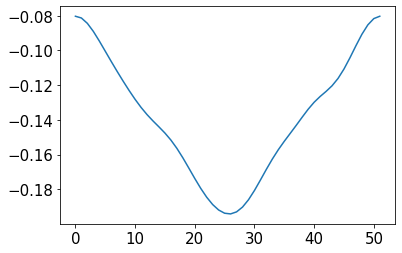

In [232]:
with torch.no_grad():
    mesh_t1 = mesh_t0.clone()
    mesh_t1[:,0] += 1/n_t
    u_pred_t1 = network(mesh_t1)
plt.plot(u_pred_t1)
plt.show()

In [236]:
with torch.no_grad():
    net_bndry = network(mesh_boundary)
print(net_bndry)

tensor([[-0.0749],
        [-0.1464],
        [-0.1431],
        [-0.1422],
        [-0.1427],
        [-0.1433],
        [-0.1436],
        [-0.1436],
        [-0.1435],
        [-0.1434],
        [-0.1433],
        [-0.1433],
        [-0.1432],
        [-0.1432],
        [-0.1432],
        [-0.1433],
        [-0.1433],
        [-0.1433],
        [-0.1434],
        [-0.1434],
        [-0.1434],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1435],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1437],
        [-0.1437],
        [-0.1437],
        [-0.1437],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1436],
        [-0.1435],
        [-0.1435],
        [-0.1434],
        [-0.1433],
        [-0.1433],
        [-0.0749],
        [-0.

RMSE: tensor(0.1182)


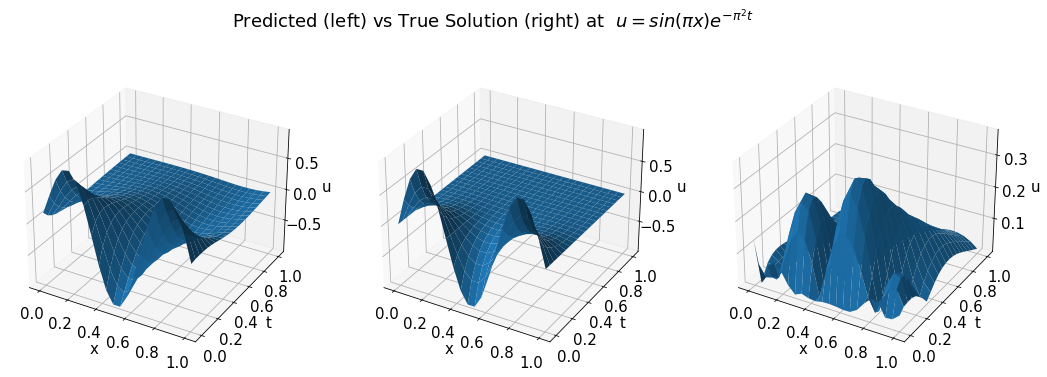

In [16]:
"""
Post training visualization
"""

import matplotlib.gridspec as gridspec

n_t = 20
n_x = n_t

fig = plt.figure(figsize=(18,6))
G = gridspec.GridSpec(1,3)

ax1 = fig.add_subplot(G[0,0], projection='3d')
ax2 = fig.add_subplot(G[0,1], projection='3d')
ax3 = fig.add_subplot(G[0,2], projection='3d')

mesh = generate_mesh(n_t, n_x)
with torch.no_grad():
    pred = network(mesh).view(n_t+2,-1)

T = mesh[:,0].reshape((n_t+2,-1))
X = mesh[:,1].reshape((n_x+2,-1))

u_exact = np.sin(np.pi*n*X)*np.exp((-(np.pi*n)**2)*k*T)

u_res = pred-u_exact
print('RMSE:', np.sqrt((u_res ** 2).mean()))

ax1.plot_surface(X,T,pred)
ax2.plot_surface(X,T,u_exact)
ax3.plot_surface(X,T,np.sqrt(u_res**2))
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
plt.suptitle(r'Predicted (left) vs True Solution (right) at  $u = sin(\pi x)e^{-\pi^2 t}$')
plt.show()